# A4: Do you AGREE?

**by Dechathon Niamsa-ard [st126235]**

### Import Necessary Libraries

In [1]:
# Standard library imports
import math
import os
import pickle
import re
from random import *

# Third-party imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

# Hugging Face imports
import datasets
from datasets import load_dataset
from datasets import DatasetDict
from transformers import AutoTokenizer
from transformers import get_linear_schedule_with_warmup

c:\Users\USER\Documents\Dechathon_N\AIT\Natural Language Understanding\A4-Do-you-AGREE\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Version used by PyTorch: {torch.version.cuda}")
print(f"GPU Name: {torch.cuda.get_device_name(0)}")
print(f"GPU Capability: {torch.cuda.get_device_capability(0)}")
print(f'Using device: {device}')

PyTorch Version: 2.10.0+cu130
CUDA Version used by PyTorch: 13.0
GPU Name: NVIDIA GeForce RTX 5060 Ti
GPU Capability: (12, 0)
Using device: cuda


In [3]:
# Set random seed for reproducibility
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Task 1. Training BERT from Scratch
**Based on Masked Language Model/BERT-update.ipynb, modify as follows: (2 points)**

1) Implement Bidirectional Encoder Representations from Transformers (BERT) from scratch, following the concepts learned in class.
2) Train the model on a suitable dataset. Ensure to source this dataset from reputable public databases or repositories.
   * It is imperative to give proper credit to the dataset source in your documentation.
3) Save the trained model weights for later use in Task 2.

**NOTE:** BERT-update.ipynb is available to use CUDA.

**NOTE:** You may refer to the BERT paper and use large corpora such as BookCorpus or English Wikipedia. However, you should only use a subset, such as 100k samples, rather than the entire dataset.

### Select the Dataset

I use the **WikiText-103** dataset from Salesforce for pre-training BERT. WikiText-103 is a large-scale language modeling dataset containing over 100 million tokens extracted from verified Good and Featured articles on Wikipedia. It provides high-quality, long-form text that is well-suited for learning contextual word representations.

The dataset is divided into three standard splits:

* **Train:** 1,801,350 rows
* **Validation:** 3,760 rows
* **Test:** 4,358 rows

I load the first 300,000 samples and filter out short entries (less than 50 characters) to ensure meaningful training data. This subset provides a good balance between training quality and computational feasibility.

**Dataset source:** https://huggingface.co/datasets/Salesforce/wikitext

```bibtex
@misc{merity2016pointer,
      title={Pointer Sentinel Mixture Models},
      author={Stephen Merity and Caiming Xiong and James Bradbury and Richard Socher},
      year={2016},
      eprint={1609.07843},
      archivePrefix={arXiv},
      primaryClass={cs.CL}
}
```

In [4]:
# Load the WikiText-103 dataset
dataset = load_dataset("wikitext", "wikitext-103-raw-v1", split="train[:300000]")

# Filter out low character count samples
dataset = dataset.filter(lambda x: len(x["text"].strip()) > 50)
dataset

Dataset({
    features: ['text'],
    num_rows: 132183
})

In [5]:
# Display the first 5 samples from the dataset
for i in range(5):
    print(f"Sample {i+1}:\n{dataset[i]['text']}")

Sample 1:
 Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " . 

Sample 2:
 The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more forgiving for series newcomers . C

In [6]:
# Preprocess the text data by converting to lowercase and removing punctuation
sentences = dataset['text']
text = [x.lower() for x in sentences] #lower case
text = [re.sub("[.,!?\\-]", '', x) for x in text] #clean all symbols
# text

# Display the first sentence and its tokenized form
for sentence in text:
    print(sentence, "_____")
    words = sentence.split()
    print(words)
    break

 senjō no valkyria 3 : unrecorded chronicles ( japanese : 戦場のヴァルキュリア3  lit  valkyria of the battlefield 3 )  commonly referred to as valkyria chronicles iii outside japan  is a tactical role @@ playing video game developed by sega and mediavision for the playstation portable  released in january 2011 in japan  it is the third game in the valkyria series  employing the same fusion of tactical and real @@ time gameplay as its predecessors  the story runs parallel to the first game and follows the " nameless "  a penal military unit serving the nation of gallia during the second europan war who perform secret black operations and are pitted against the imperial unit " calamaty raven "  
 _____
['senjō', 'no', 'valkyria', '3', ':', 'unrecorded', 'chronicles', '(', 'japanese', ':', '戦場のヴァルキュリア3', 'lit', 'valkyria', 'of', 'the', 'battlefield', '3', ')', 'commonly', 'referred', 'to', 'as', 'valkyria', 'chronicles', 'iii', 'outside', 'japan', 'is', 'a', 'tactical', 'role', '@@', 'playing', 'vi

### Making vocabs

Build a word-level vocabulary from the preprocessed WikiText data. Each unique word is assigned a unique integer ID. Reserve special token IDs for:
- `[PAD]` (ID: 0): Padding token to fill sequences to equal length
- `[CLS]` (ID: 1): Classification token placed at the beginning of each input
- `[SEP]` (ID: 2): Separator token placed between and after sentences
- `[MASK]` (ID: 3): Mask token used for Masked Language Modeling during pre-training

Also create a reverse mapping (`id2word`) for converting token IDs back to words during inference.

In [7]:
# Combine everything into one to make vocab
word_list = list(set(" ".join(text).split()))
word2id = {'[PAD]': 0, '[CLS]': 1, '[SEP]': 2, '[MASK]': 3} # Special tokens

# Create the word2id in a single pass
for i, w in tqdm(enumerate(word_list), desc="Creating word2id"):
    word2id[w] = i + 4  # because 0-3 are already occupied

# Precompute the id2word mapping (this can be done once after word2id is fully populated)
id2word = {v: k for k, v in word2id.items()}
vocab_size = len(word2id)
vocab_size

Creating word2id: 199401it [00:00, 2556452.08it/s]


199405

In [8]:
vocab_size = len(word2id)

# List of all tokens for the whole text
token_list = []

# Process sentences more efficiently
for sentence in tqdm(text, desc="Processing sentences"):
    token_list.append([word2id[word] for word in sentence.split()])

# Now token_list contains the tokenized sentences

Processing sentences: 100%|██████████| 132183/132183 [00:01<00:00, 75151.02it/s]


In [9]:
#take a look at sentences
sentences[:2]

[' Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " . \n',
 " The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more forgiving for series newcomers . Character desi

In [10]:
#take a look at token_list
token_list[:2]

[[135545,
  9675,
  61793,
  194145,
  16141,
  174428,
  48111,
  136541,
  178867,
  16141,
  60643,
  34713,
  61793,
  88356,
  96108,
  131719,
  194145,
  12811,
  61956,
  132196,
  109341,
  188402,
  61793,
  48111,
  154549,
  116947,
  124779,
  44820,
  17004,
  157958,
  3409,
  50133,
  2978,
  3844,
  68240,
  133914,
  22274,
  131270,
  77750,
  104131,
  114742,
  96108,
  8955,
  91938,
  144431,
  92809,
  17382,
  108510,
  92809,
  124779,
  129240,
  44820,
  96108,
  6538,
  68240,
  92809,
  96108,
  61793,
  20087,
  55585,
  96108,
  29900,
  98463,
  88356,
  157958,
  77750,
  120124,
  50133,
  42082,
  114807,
  188402,
  13215,
  197941,
  96108,
  29083,
  146350,
  63845,
  109341,
  96108,
  140710,
  68240,
  77750,
  145771,
  96108,
  89286,
  24766,
  89286,
  17004,
  113163,
  186601,
  43754,
  42592,
  96108,
  25238,
  88356,
  114221,
  136832,
  96108,
  95902,
  3322,
  111234,
  52738,
  32631,
  32562,
  180387,
  80644,
  77750,
  12531

In [11]:
#testing one sentence
for tokens in token_list[0]:
    print(id2word[tokens])

senjō
no
valkyria
3
:
unrecorded
chronicles
(
japanese
:
戦場のヴァルキュリア3
lit
valkyria
of
the
battlefield
3
)
commonly
referred
to
as
valkyria
chronicles
iii
outside
japan
is
a
tactical
role
@@
playing
video
game
developed
by
sega
and
mediavision
for
the
playstation
portable
released
in
january
2011
in
japan
it
is
the
third
game
in
the
valkyria
series
employing
the
same
fusion
of
tactical
and
real
@@
time
gameplay
as
its
predecessors
the
story
runs
parallel
to
the
first
game
and
follows
the
"
nameless
"
a
penal
military
unit
serving
the
nation
of
gallia
during
the
second
europan
war
who
perform
secret
black
operations
and
are
pitted
against
the
imperial
unit
"
calamaty
raven
"


### Data Loader

I need to build a custom data loader for pre-training BERT. The data loader constructs training batches that support both of BERT's pre-training objectives:

1. **Masked Language Modeling (MLM):** Randomly mask 15% of tokens in each sequence. Among these, 80% are replaced with `[MASK]`, 10% with a random token, and 10% are left unchanged. The model learns to predict the original tokens.

2. **Next Sentence Prediction (NSP):** Construct pairs of sentences where 50% are actual consecutive sentences (positive pairs) and 50% are random pairs (negative pairs). The model learns to predict whether the second sentence follows the first.

Each training sample is structured as: `[CLS] sentence_A [SEP] sentence_B [SEP]` with corresponding segment embeddings to distinguish the two sentences. All sequences are padded to `max_len` for batching.

In [12]:
# Hyperparameters for data loader
batch_size = 6      # Number of samples per batch (half positive, half negative)
max_mask   = 5      # Maximum number of masked tokens per sequence
max_len    = 512    # Maximum sequence length (padded to this length)

In [13]:
def make_batch():
    """
    Create a single training batch for BERT pre-training.
    
    Each batch contains equal numbers of positive (next sentence) and
    negative (random sentence) pairs. For each pair, I apply:
    - Token embedding with [CLS] and [SEP] special tokens
    - Segment embedding to distinguish sentence A from sentence B  
    - Masked Language Modeling (15% masking with 80/10/10 strategy)
    - Padding to max_len
    
    Returns:
        list: A batch of [input_ids, segment_ids, masked_tokens, masked_pos, isNext]
    """
    batch = []
    positive = negative = 0  # Count to ensure balanced positive/negative pairs

    while positive != batch_size / 2 or negative != batch_size / 2:
        # Randomly choose two sentence indices
        tokens_a_index, tokens_b_index = randrange(len(sentences)), randrange(len(sentences))
        # Retrieve the corresponding token sequences
        tokens_a, tokens_b = token_list[tokens_a_index], token_list[tokens_b_index]

        # Skip if combined length exceeds max_len (accounting for [CLS] and two [SEP] tokens)
        if len(tokens_a) + len(tokens_b) + 3 > max_len:
            continue

        # 1. Token embedding: prepend [CLS], insert [SEP] between sentences, append [SEP]
        input_ids = [word2id['[CLS]']] + tokens_a + [word2id['[SEP]']] + tokens_b + [word2id['[SEP]']]

        # 2. Segment embedding: 0 for sentence A (including [CLS] and first [SEP]), 1 for sentence B
        segment_ids = [0] * (1 + len(tokens_a) + 1) + [1] * (len(tokens_b) + 1)

        # 3. Masked Language Modeling
        # Mask 15% of tokens, but at least 1 and at most max_mask
        n_pred = min(max_mask, max(1, int(round(len(input_ids) * 0.15))))
        # Get candidate positions (exclude [CLS] and [SEP] tokens)
        cand_masked_pos = [i for i, token in enumerate(input_ids)
                          if token != word2id['[CLS]'] and token != word2id['[SEP]']]
        shuffle(cand_masked_pos)
        
        masked_tokens, masked_pos = [], []
        for pos in cand_masked_pos[:n_pred]:
            masked_pos.append(pos)          # Remember the position
            masked_tokens.append(input_ids[pos])  # Remember the original token
            # Apply masking strategy: 80% [MASK], 10% random token, 10% unchanged
            if random() < 0.1:       # 10% - replace with random token
                index = randint(0, vocab_size - 1)
                input_ids[pos] = word2id[id2word[index]]
            elif random() < 0.9:     # 80% - replace with [MASK]
                input_ids[pos] = word2id['[MASK]']
            # else: 10% - keep original token (do nothing)

        # 4. Pad input_ids and segment_ids to max_len
        n_pad = max_len - len(input_ids)
        input_ids.extend([0] * n_pad)
        segment_ids.extend([0] * n_pad)

        # Pad masked_tokens and masked_pos to max_mask length
        if max_mask > n_pred:
            n_pad = max_mask - n_pred
            masked_tokens.extend([0] * n_pad)
            masked_pos.extend([0] * n_pad)

        # Check if sentence B actually follows sentence A (Next Sentence Prediction)
        if tokens_a_index + 1 == tokens_b_index and positive < batch_size / 2:
            batch.append([input_ids, segment_ids, masked_tokens, masked_pos, True])  # IsNext
            positive += 1
        elif tokens_a_index + 1 != tokens_b_index and negative < batch_size / 2:
            batch.append([input_ids, segment_ids, masked_tokens, masked_pos, False])  # NotNext
            negative += 1

    return batch

In [14]:
# Test creating a batch and inspect shapes
batch = make_batch()
print(f"Batch size: {len(batch)}")

# Deconstruct batch into tensors using map and zip
input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(*batch))
print(f"input_ids shape:     {input_ids.shape}")
print(f"segment_ids shape:   {segment_ids.shape}")
print(f"masked_tokens shape: {masked_tokens.shape}")
print(f"masked_pos shape:    {masked_pos.shape}")
print(f"isNext shape:        {isNext.shape}")

Batch size: 6
input_ids shape:     torch.Size([6, 512])
segment_ids shape:   torch.Size([6, 512])
masked_tokens shape: torch.Size([6, 5])
masked_pos shape:    torch.Size([6, 5])
isNext shape:        torch.Size([6])


### BERT Model Architecture

I implement BERT from scratch following the original paper. The model consists of the following components:

1. **Embedding Layer:** Combines three embeddings - token embedding, positional embedding, and segment embedding - followed by Layer Normalization.

2. **Scaled Dot-Product Attention:** Computes attention weights as $\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$ with padding mask support.

3. **Multi-Head Attention:** Projects queries, keys, and values into multiple heads, applies scaled dot-product attention in parallel, then concatenates and projects back.

4. **Position-wise Feed-Forward Network:** Two linear transformations with GELU activation: $\text{FFN}(x) = W_2 \cdot \text{GELU}(W_1 x + b_1) + b_2$.

5. **Encoder Layer:** Combines multi-head attention and feed-forward network with residual connections and layer normalization.

6. **Full BERT Model:** Stacks multiple encoder layers and adds two prediction heads for MLM and NSP tasks.

In [15]:
# ==================== BERT Model Hyperparameters ====================
n_layers   = 6     # Number of Transformer encoder layers
n_heads    = 8     # Number of attention heads in Multi-Head Attention
d_model    = 768   # Hidden size / embedding dimension
d_ff       = d_model * 4  # Feed-forward intermediate dimension (4 * d_model = 3072)
d_k = d_v  = 64    # Dimension of each attention head for keys/queries and values
n_segments = 2     # Number of segment types (sentence A = 0, sentence B = 1)

print(f"BERT Configuration:")
print(f"  Layers: {n_layers}, Heads: {n_heads}, d_model: {d_model}")
print(f"  d_ff: {d_ff}, d_k: {d_k}, d_v: {d_v}")
print(f"  Vocab size: {vocab_size}, Max length: {max_len}")

BERT Configuration:
  Layers: 6, Heads: 8, d_model: 768
  d_ff: 3072, d_k: 64, d_v: 64
  Vocab size: 199405, Max length: 512


In [16]:
class Embedding(nn.Module):
    """
    BERT Embedding Layer.
    
    Combines three types of embeddings:
    - Token embedding: maps vocabulary indices to dense vectors
    - Position embedding: encodes the position of each token in the sequence
    - Segment embedding: distinguishes between sentence A and sentence B
    
    All three are summed and passed through Layer Normalization.
    """
    def __init__(self, vocab_size, max_len, n_segments, d_model, device):
        super(Embedding, self).__init__()
        self.tok_embed = nn.Embedding(vocab_size, d_model)   # Token embedding
        self.pos_embed = nn.Embedding(max_len, d_model)      # Position embedding
        self.seg_embed = nn.Embedding(n_segments, d_model)   # Segment (token type) embedding
        self.norm = nn.LayerNorm(d_model)
        self.device = device

    def forward(self, x, seg):
        # x: (batch_size, seq_len), seg: (batch_size, seq_len)
        seq_len = x.size(1)
        # Create position indices [0, 1, 2, ..., seq_len-1]
        pos = torch.arange(seq_len, dtype=torch.long).to(self.device)
        pos = pos.unsqueeze(0).expand_as(x)  # (seq_len,) -> (batch_size, seq_len)
        # Sum all three embeddings and normalize
        embedding = self.tok_embed(x) + self.pos_embed(pos) + self.seg_embed(seg)
        return self.norm(embedding)

In [17]:
def get_attn_pad_mask(seq_q, seq_k, device):
    """
    Create attention padding mask.
    
    Generates a boolean mask where True indicates padding positions (token id = 0).
    This prevents the attention mechanism from attending to padding tokens.
    
    Args:
        seq_q: Query sequence tensor (batch_size, len_q)
        seq_k: Key sequence tensor (batch_size, len_k)
        device: Device to place the mask on
        
    Returns:
        Tensor of shape (batch_size, len_q, len_k) with True at padding positions
    """
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(0) marks PAD token positions as True
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1).to(device)  # (batch_size, 1, len_k)
    return pad_attn_mask.expand(batch_size, len_q, len_k)      # (batch_size, len_q, len_k)

In [18]:
class ScaledDotProductAttention(nn.Module):
    """
    Scaled Dot-Product Attention mechanism.
    
    Computes attention as: Attention(Q, K, V) = softmax(QK^T / sqrt(d_k)) * V
    Applies a mask to prevent attending to padding positions.
    """
    def __init__(self, d_k, device):
        super(ScaledDotProductAttention, self).__init__()
        self.scale = torch.sqrt(torch.FloatTensor([d_k])).to(device)

    def forward(self, Q, K, V, attn_mask):
        # Q, K, V: (batch_size, n_heads, seq_len, d_k)
        # Compute attention scores
        scores = torch.matmul(Q, K.transpose(-1, -2)) / self.scale  # (batch_size, n_heads, len_q, len_k)
        # Apply mask: fill masked positions with -1e9 (effectively -infinity after softmax)
        scores.masked_fill_(attn_mask, -1e9)
        # Compute attention weights via softmax
        attn = nn.Softmax(dim=-1)(scores)
        # Compute weighted sum of values
        context = torch.matmul(attn, V)
        return context, attn

In [19]:
class MultiHeadAttention(nn.Module):
    """
    Multi-Head Attention mechanism.
    
    Projects input into multiple attention heads, applies scaled dot-product
    attention in parallel, concatenates results, and projects back to d_model.
    Includes residual connection and layer normalization.
    """
    def __init__(self, n_heads, d_model, d_k, device):
        super(MultiHeadAttention, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_k
        # Linear projections for Q, K, V
        self.W_Q = nn.Linear(d_model, d_k * n_heads)
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, self.d_v * n_heads)
        # Output projection
        self.fc = nn.Linear(n_heads * self.d_v, d_model)
        self.layer_norm = nn.LayerNorm(d_model)
        self.device = device

    def forward(self, Q, K, V, attn_mask):
        # Q, K, V: (batch_size, seq_len, d_model)
        residual, batch_size = Q, Q.size(0)
        
        # Project and reshape: (batch_size, seq_len, d_model) -> (batch_size, n_heads, seq_len, d_k)
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        k_s = self.W_K(K).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        v_s = self.W_V(V).view(batch_size, -1, self.n_heads, self.d_v).transpose(1, 2)

        # Expand attention mask for all heads: (batch_size, n_heads, len_q, len_k)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_heads, 1, 1)

        # Apply scaled dot-product attention
        context, attn = ScaledDotProductAttention(self.d_k, self.device)(q_s, k_s, v_s, attn_mask)
        
        # Concatenate heads: (batch_size, seq_len, n_heads * d_v)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.d_v)
        
        # Final linear projection
        output = self.fc(context)
        
        # Residual connection + layer normalization
        return self.layer_norm(output + residual), attn

In [20]:
class PoswiseFeedForwardNet(nn.Module):
    """
    Position-wise Feed-Forward Network.
    
    Applies two linear transformations with a GELU activation in between:
    FFN(x) = W2 * GELU(W1 * x + b1) + b2
    
    This expands the representation to d_ff dimensions and then compresses back to d_model.
    """
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)   # Expansion layer
        self.fc2 = nn.Linear(d_ff, d_model)   # Compression layer

    def forward(self, x):
        # (batch_size, seq_len, d_model) -> (batch_size, seq_len, d_ff) -> (batch_size, seq_len, d_model)
        return self.fc2(F.gelu(self.fc1(x)))

In [21]:
class EncoderLayer(nn.Module):
    """
    Single Transformer Encoder Layer.
    
    Consists of:
    1. Multi-Head Self-Attention with residual connection and layer norm
    2. Position-wise Feed-Forward Network
    """
    def __init__(self, n_heads, d_model, d_ff, d_k, device):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(n_heads, d_model, d_k, device)
        self.pos_ffn = PoswiseFeedForwardNet(d_model, d_ff)

    def forward(self, enc_inputs, enc_self_attn_mask):
        # Self-attention: Q=K=V=enc_inputs
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask)
        # Feed-forward network
        enc_outputs = self.pos_ffn(enc_outputs)  # (batch_size, seq_len, d_model)
        return enc_outputs, attn

In [22]:
class BERT(nn.Module):
    """
    Bidirectional Encoder Representations from Transformers (BERT).
    
    This model implements the full BERT architecture with two pre-training objectives:
    1. Masked Language Model (MLM): Predicts masked tokens in the input sequence
    2. Next Sentence Prediction (NSP): Predicts whether sentence B follows sentence A
    
    The model also provides a method to extract the last hidden state for downstream tasks
    like Sentence-BERT.
    
    Architecture:
    - Embedding layer (token + position + segment)
    - Stack of Transformer encoder layers
    - MLM head (linear + GELU + layer norm + decoder)
    - NSP head (tanh activation + classifier)
    """
    def __init__(self, n_layers, n_heads, d_model, d_ff, d_k, n_segments, vocab_size, max_len, device):
        super(BERT, self).__init__()
        # Store hyperparameters for later reference (useful when saving/loading)
        self.params = {
            'n_layers': n_layers, 'n_heads': n_heads, 'd_model': d_model,
            'd_ff': d_ff, 'd_k': d_k, 'n_segments': n_segments,
            'vocab_size': vocab_size, 'max_len': max_len
        }
        
        # Embedding layer
        self.embedding = Embedding(vocab_size, max_len, n_segments, d_model, device)
        
        # Stack of Transformer encoder layers
        self.layers = nn.ModuleList([
            EncoderLayer(n_heads, d_model, d_ff, d_k, device) for _ in range(n_layers)
        ])
        
        # NSP head: [CLS] token -> tanh -> binary classifier
        self.fc = nn.Linear(d_model, d_model)
        self.activ = nn.Tanh()
        self.classifier = nn.Linear(d_model, 2)  # IsNext / NotNext
        
        # MLM head: masked positions -> linear -> GELU -> layer norm -> decoder
        self.linear = nn.Linear(d_model, d_model)
        self.norm = nn.LayerNorm(d_model)
        
        # Decoder shares weights with the token embedding layer (weight tying)
        embed_weight = self.embedding.tok_embed.weight
        n_vocab, n_dim = embed_weight.size()
        self.decoder = nn.Linear(n_dim, n_vocab, bias=False)
        self.decoder.weight = embed_weight
        self.decoder_bias = nn.Parameter(torch.zeros(n_vocab))
        
        self.device = device

    def forward(self, input_ids, segment_ids, masked_pos):
        """
        Forward pass for BERT pre-training.
        
        Args:
            input_ids: Token indices (batch_size, seq_len)
            segment_ids: Segment indices (batch_size, seq_len)
            masked_pos: Positions of masked tokens (batch_size, max_mask)
            
        Returns:
            logits_lm: MLM logits (batch_size, max_mask, vocab_size)
            logits_nsp: NSP logits (batch_size, 2)
        """
        # Get contextualized embeddings from the encoder stack
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids, self.device)
        for layer in self.layers:
            output, enc_self_attn = layer(output, enc_self_attn_mask)
        # output: (batch_size, seq_len, d_model)
        
        # 1. Next Sentence Prediction: use the [CLS] token representation (position 0)
        h_pooled = self.activ(self.fc(output[:, 0]))   # (batch_size, d_model)
        logits_nsp = self.classifier(h_pooled)          # (batch_size, 2)

        # 2. Masked Language Model: extract representations at masked positions
        masked_pos = masked_pos[:, :, None].expand(-1, -1, output.size(-1))  # (batch_size, max_mask, d_model)
        h_masked = torch.gather(output, 1, masked_pos)  # (batch_size, max_mask, d_model)
        h_masked = self.norm(F.gelu(self.linear(h_masked)))
        logits_lm = self.decoder(h_masked) + self.decoder_bias  # (batch_size, max_mask, vocab_size)

        return logits_lm, logits_nsp

    def get_last_hidden_state(self, input_ids, segment_ids):
        """
        Extract the last hidden state from the encoder (used for downstream tasks like S-BERT).
        
        Args:
            input_ids: Token indices (batch_size, seq_len)
            segment_ids: Segment indices (batch_size, seq_len)
            
        Returns:
            output: Last hidden state (batch_size, seq_len, d_model)
        """
        output = self.embedding(input_ids, segment_ids)
        enc_self_attn_mask = get_attn_pad_mask(input_ids, input_ids, self.device)
        for layer in self.layers:
            output, enc_self_attn = layer(output, enc_self_attn_mask)
        return output

### Training BERT

I now train the BERT model using the two pre-training objectives:
- **Masked Language Model (MLM):** Cross-entropy loss between predicted and actual masked tokens
- **Next Sentence Prediction (NSP):** Cross-entropy loss for binary classification (IsNext / NotNext)

The total loss is the sum of both objectives: $\mathcal{L} = \mathcal{L}_{MLM} + \mathcal{L}_{NSP}$

I use the Adam optimizer with a learning rate of 0.0001. Training is done for 100 epochs, where each epoch creates a new random batch with fresh masking patterns.

In [23]:
# Initialize the BERT model and move to GPU
num_epoch = 100

model = BERT(
    n_layers=n_layers,
    n_heads=n_heads,
    d_model=d_model,
    d_ff=d_ff,
    d_k=d_k,
    n_segments=n_segments,
    vocab_size=vocab_size,
    max_len=max_len,
    device=device
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 192,717,807
Trainable parameters: 192,717,807


### BERT Model Summary

I display the full model architecture and a detailed parameter breakdown to verify the model structure before training. The table below summarizes all hyperparameters used for pre-training.

| Component | Detail |
|---|---|
| **Encoder Layers** | 6 |
| **Attention Heads** | 8 |
| **Hidden Size (d_model)** | 768 |
| **Feed-Forward Size (d_ff)** | 3072 (4 × d_model) |
| **Head Dimension (d_k = d_v)** | 64 |
| **Vocabulary Size** | Built from WikiText-103 |
| **Max Sequence Length** | 512 |
| **Pre-training Objectives** | MLM + NSP |
| **Optimizer** | Adam (lr = 1e-4) |
| **Epochs** | 100 |
| **Batch Size** | 6 |

In [24]:
# ==================== BERT Model Structure & Parameters ====================
print("=" * 70)
print("BERT Pre-training Model Architecture")
print("=" * 70)
print(model)
print("\n" + "=" * 70)
print("Layer-wise Parameter Count")
print("=" * 70)

# Detailed parameter breakdown
param_summary = {}
for name, param in model.named_parameters():
    layer_group = name.split('.')[0]  # Top-level module name
    count = param.numel()
    param_summary[layer_group] = param_summary.get(layer_group, 0) + count

for group, count in param_summary.items():
    print(f"  {group:20s}: {count:>12,} params")

total = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n  {'Total':20s}: {total:>12,} params")
print(f"  {'Trainable':20s}: {trainable:>12,} params")
print(f"  {'Non-trainable':20s}: {total - trainable:>12,} params")

print("\n" + "=" * 70)
print("Hyperparameters Summary")
print("=" * 70)
hyperparams = {
    "n_layers": n_layers, "n_heads": n_heads, "d_model": d_model,
    "d_ff": d_ff, "d_k / d_v": d_k, "n_segments": n_segments,
    "vocab_size": vocab_size, "max_len": max_len,
    "optimizer": "Adam", "learning_rate": 0.0001,
    "epochs": num_epoch, "batch_size": batch_size,
    "max_mask": max_mask, "pre-training tasks": "MLM + NSP",
}
for k, v in hyperparams.items():
    print(f"  {k:20s}: {v}")

BERT Pre-training Model Architecture
BERT(
  (embedding): Embedding(
    (tok_embed): Embedding(199405, 768)
    (pos_embed): Embedding(512, 768)
    (seg_embed): Embedding(2, 768)
    (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (enc_self_attn): MultiHeadAttention(
        (W_Q): Linear(in_features=768, out_features=512, bias=True)
        (W_K): Linear(in_features=768, out_features=512, bias=True)
        (W_V): Linear(in_features=768, out_features=512, bias=True)
        (fc): Linear(in_features=512, out_features=768, bias=True)
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
      (pos_ffn): PoswiseFeedForwardNet(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
      )
    )
  )
  (fc): Linear(in_features=768, out_features=768, bias=True)
  (activ): Tanh()
  (classifier): Linear(

In [25]:
# ==================== BERT Pre-training Loop ====================
for epoch in tqdm(range(num_epoch), desc="Pre-training BERT"):
    # Create a fresh batch each epoch (different masking patterns and sentence pairs)
    batch = make_batch()
    input_ids, segment_ids, masked_tokens, masked_pos, isNext = map(torch.LongTensor, zip(*batch))

    # Move all tensors to the active device (GPU)
    input_ids = input_ids.to(device)
    segment_ids = segment_ids.to(device)
    masked_tokens = masked_tokens.to(device)
    masked_pos = masked_pos.to(device)
    isNext = isNext.to(device)

    # Zero gradients
    optimizer.zero_grad()

    # Forward pass
    logits_lm, logits_nsp = model(input_ids, segment_ids, masked_pos)
    # logits_lm: (batch_size, max_mask, vocab_size)
    # logits_nsp: (batch_size, 2)

    # 1. MLM loss: compare predicted tokens with actual masked tokens
    # logits_lm.transpose(1,2): (batch_size, vocab_size, max_mask)
    # masked_tokens: (batch_size, max_mask)
    loss_lm = criterion(logits_lm.transpose(1, 2), masked_tokens)
    loss_lm = loss_lm.float().mean()

    # 2. NSP loss: binary classification (IsNext / NotNext)
    loss_nsp = criterion(logits_nsp, isNext)

    # 3. Combined loss
    loss = loss_lm + loss_nsp

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1:3d}/{num_epoch} | Loss: {loss.item():.6f} | MLM Loss: {loss_lm.item():.6f} | NSP Loss: {loss_nsp.item():.6f}")

print(f"\nTraining complete! Final loss: {loss.item():.6f}")

Pre-training BERT:  10%|█         | 10/100 [02:03<20:58, 13.99s/it]

Epoch  10/100 | Loss: 99.708092 | MLM Loss: 99.014351 | NSP Loss: 0.693744


Pre-training BERT:  20%|██        | 20/100 [04:03<18:57, 14.22s/it]

Epoch  20/100 | Loss: 97.092819 | MLM Loss: 96.399139 | NSP Loss: 0.693678


Pre-training BERT:  30%|███       | 30/100 [06:54<18:08, 15.55s/it]

Epoch  30/100 | Loss: 82.626106 | MLM Loss: 81.932930 | NSP Loss: 0.693176


Pre-training BERT:  40%|████      | 40/100 [09:09<10:08, 10.14s/it]

Epoch  40/100 | Loss: 76.424911 | MLM Loss: 75.731644 | NSP Loss: 0.693271


Pre-training BERT:  50%|█████     | 50/100 [11:32<08:35, 10.30s/it]

Epoch  50/100 | Loss: 70.669983 | MLM Loss: 69.976837 | NSP Loss: 0.693144


Pre-training BERT:  60%|██████    | 60/100 [13:42<06:57, 10.44s/it]

Epoch  60/100 | Loss: 73.599632 | MLM Loss: 72.906494 | NSP Loss: 0.693137


Pre-training BERT:  70%|███████   | 70/100 [16:06<04:10,  8.36s/it]

Epoch  70/100 | Loss: 56.410080 | MLM Loss: 55.716854 | NSP Loss: 0.693227


Pre-training BERT:  80%|████████  | 80/100 [20:17<09:38, 28.92s/it]

Epoch  80/100 | Loss: 62.496159 | MLM Loss: 61.802979 | NSP Loss: 0.693180


Pre-training BERT:  90%|█████████ | 90/100 [23:44<02:49, 16.98s/it]

Epoch  90/100 | Loss: 55.269810 | MLM Loss: 54.576572 | NSP Loss: 0.693237


Pre-training BERT: 100%|██████████| 100/100 [26:19<00:00, 15.79s/it]

Epoch 100/100 | Loss: 62.228508 | MLM Loss: 61.535118 | NSP Loss: 0.693388

Training complete! Final loss: 62.228508


### BERT Pre-training Inference Test

I verify that the pre-trained BERT model can correctly predict masked tokens and next sentence relationships. I pick one sample from the batch and check:
- Whether the predicted masked tokens match the original tokens
- Whether the Next Sentence Prediction is correct

In [26]:
# ==================== Inference Test ====================
model.eval()
with torch.no_grad():
    # Take the third sample from the last batch for testing
    test_input_ids, test_segment_ids, test_masked_tokens, test_masked_pos, test_isNext = map(
        torch.LongTensor, zip(batch[2])
    )
    
    # Print the input sequence (excluding padding)
    print("Input sequence:")
    print([id2word[w.item()] for w in test_input_ids[0] if id2word[w.item()] != '[PAD]'])
    
    # Move tensors to device
    test_input_ids = test_input_ids.to(device)
    test_segment_ids = test_segment_ids.to(device)
    test_masked_tokens = test_masked_tokens.to(device)
    test_masked_pos = test_masked_pos.to(device)
    test_isNext = test_isNext.to(device)
    
    # Forward pass
    logits_lm, logits_nsp = model(test_input_ids, test_segment_ids, test_masked_pos)
    
    # Predict masked tokens: get the token with highest probability
    predicted_tokens = logits_lm.data.cpu().max(2)[1][0].data.numpy()
    
    print(f"\nMasked tokens (ground truth): {[id2word[pos.item()] for pos in test_masked_tokens[0]]}")
    print(f"Predicted masked tokens:      {[id2word[pos.item()] for pos in predicted_tokens]}")
    
    # Predict NSP
    predicted_nsp = logits_nsp.cpu().data.max(1)[1][0].data.numpy()
    print(f"\nActual isNext:    {True if test_isNext else False}")
    print(f"Predicted isNext: {True if predicted_nsp else False}")

Input sequence:
['[CLS]', 'a', 'mimed', 'stage', '[MASK]', 'thunderbirds', ':', 'fab', 'has', 'grandidier', 'internationally', 'and', 'popularised', 'a', 'staccato', 'style', 'of', 'movement', 'known', 'colloquially', 'as', 'the', '"', 'thunderbirds', 'walk', '"', 'the', 'production', 'has', 'periodically', 'been', 'revived', 'as', 'thunderbirds', ':', 'fab', '–', 'the', 'next', 'generation', '[SEP]', 'richard', 'barre', '(', 'c', '1130', '–', 'c', '1202', ')', 'was', 'a', 'medieval', 'english', 'justice', 'clergyman', 'and', 'scholar', 'he', 'was', 'educated', 'at', 'the', 'law', 'school', 'of', 'bologna', 'and', 'entered', 'royal', 'service', 'under', 'king', 'henry', 'ii', 'of', 'england', 'later', 'working', 'for', 'henry', "'s", 'son', 'and', 'successor', 'richard', 'i', 'he', 'was', 'also', 'briefly', 'in', 'the', 'household', 'of', 'henry', "'s", 'son', 'henry', 'the', 'young', 'king', 'barre', 'served', 'the', 'elder', 'henry', '[MASK]', 'a', '[MASK]', 'and', 'was', 'involved',

### Save Pre-trained BERT Model

I save the pre-trained BERT model weights along with the vocabulary mappings and model hyperparameters. These will be loaded in Task 2 for fine-tuning with Sentence-BERT.

In [27]:
import pickle

# Create model directory if it doesn't exist
os.makedirs('model', exist_ok=True)

# Save the model state dict and hyperparameters
torch.save({
    'model_state_dict': model.state_dict(),
    'model_params': model.params,
}, 'model/bert_pretrained.pth')

# Save vocabulary mappings (needed for tokenization in Task 2)
with open('model/vocab.pkl', 'wb') as f:
    pickle.dump({
        'word2id': word2id,
        'id2word': id2word,
        'vocab_size': vocab_size,
    }, f)

print("Model saved to model/bert_pretrained.pth")
print("Vocabulary saved to model/vocab.pkl")

Model saved to model/bert_pretrained.pth
Vocabulary saved to model/vocab.pkl


## Task 2. Sentence Embedding with Sentence BERT
**Implement trained BERT from task 1 with siamese network structures to derive semantically meaningful sentence embeddings that can be compared using cosine-similarity. (3 points)**

1) Use the SNLI OR MNLI datasets from Hugging Face, or any dataset related to classification tasks.
2) Reproduce training the Sentence-BERT as described in the paper.
3) Focus on the Classification Objective Function: (SoftmaxLoss)

$$o=softmax(W^{T}\cdot(u,v,|u-v|))$$

**HINT:** You can take a look how to implement Softmax loss in the file 04 Huggingface/Appendix - Sentence Embedding/S-BERT.ipynb.

![/assets/SBERT.png](assets/SBERT.png)

### Load Pre-trained BERT and Vocabulary

I load the pre-trained BERT model from Task 1 along with the vocabulary mappings. If the model/vocab are already in memory from Task 1, this step ensures they can also be loaded independently.

In [28]:
import pickle

# Load vocabulary mappings
with open('model/vocab.pkl', 'rb') as f:
    vocab_data = pickle.load(f)
    word2id = vocab_data['word2id']
    id2word = vocab_data['id2word']
    vocab_size = vocab_data['vocab_size']

print(f"Vocabulary size: {vocab_size}")

# Load the pre-trained BERT model checkpoint
checkpoint = torch.load('model/bert_pretrained.pth', map_location=device)
params = checkpoint['model_params']

# Reconstruct the BERT model with the same hyperparameters
bert_model = BERT(
    n_layers=params['n_layers'],
    n_heads=params['n_heads'],
    d_model=params['d_model'],
    d_ff=params['d_ff'],
    d_k=params['d_k'],
    n_segments=params['n_segments'],
    vocab_size=params['vocab_size'],
    max_len=params['max_len'],
    device=device
).to(device)

# Load the pre-trained weights
bert_model.load_state_dict(checkpoint['model_state_dict'])
print("Pre-trained BERT model loaded successfully!")
print(f"Model config: {params}")

Vocabulary size: 199405
Pre-trained BERT model loaded successfully!
Model config: {'n_layers': 6, 'n_heads': 8, 'd_model': 768, 'd_ff': 3072, 'd_k': 64, 'n_segments': 2, 'vocab_size': 199405, 'max_len': 512}


### Load NLI Dataset (SNLI)

I use the **SNLI (Stanford Natural Language Inference)** dataset for training Sentence-BERT. SNLI is one of the most widely used benchmarks for natural language inference, containing approximately 570K human-annotated sentence pairs. Each pair consists of a premise and a hypothesis, labeled as entailment, neutral, or contradiction.

|Dataset Split|	Number of Instances in Split|
| :--:| :--: |
|Train|	550,152|
|Validation|	10,000|
|Test|	10,000|

Labels: `0 = entailment`, `1 = neutral`, `2 = contradiction`

I filter out samples with label `-1` (where annotators could not agree on a label).

**Dataset source:** https://huggingface.co/datasets/stanfordnlp/snli

```bibtex
@inproceedings{bowman-etal-2015-large,
    title = "A large annotated corpus for learning natural language inference",
    author = "Bowman, Samuel R.  and
      Angeli, Gabor  and
      Potts, Christopher  and
      Manning, Christopher D.",
    editor = "M{\`a}rquez, Llu{\'\i}s  and
      Callison-Burch, Chris  and
      Su, Jian",
    booktitle = "Proceedings of the 2015 Conference on Empirical Methods in Natural Language Processing",
    month = sep,
    year = "2015",
    address = "Lisbon, Portugal",
    publisher = "Association for Computational Linguistics",
    url = "https://aclanthology.org/D15-1075",
    doi = "10.18653/v1/D15-1075",
    pages = "632--642",
}

```

In [29]:
# Load SNLI dataset from Hugging Face
snli = datasets.load_dataset('stanfordnlp/snli')

print(f"SNLI splits: {list(snli.keys())}")
print(f"SNLI features: {snli['train'].features}")
print(f"SNLI train size: {len(snli['train']):,}")
print(f"SNLI test size: {len(snli['test']):,}")
print(f"SNLI validation size: {len(snli['validation']):,}")

SNLI splits: ['test', 'validation', 'train']
SNLI features: {'premise': Value('string'), 'hypothesis': Value('string'), 'label': ClassLabel(names=['entailment', 'neutral', 'contradiction'])}
SNLI train size: 550,152
SNLI test size: 10,000
SNLI validation size: 10,000


In [30]:
# Filter out samples with label = -1 in SNLI (where no agreement was reached)
snli = snli.filter(lambda x: x['label'] != -1)

# Verify labels are clean
print(f"SNLI train labels: {np.unique(snli['train']['label'])}")
print(f"SNLI test labels:  {np.unique(snli['test']['label'])}")
print(f"SNLI val labels:   {np.unique(snli['validation']['label'])}")
print(f"\nFiltered sizes:")
print(f"  Train:      {len(snli['train']):,}")
print(f"  Test:       {len(snli['test']):,}")
print(f"  Validation: {len(snli['validation']):,}")

SNLI train labels: [0 1 2]
SNLI test labels:  [0 1 2]
SNLI val labels:   [0 1 2]

Filtered sizes:
  Train:      549,367
  Test:       9,824
  Validation: 9,842


In [31]:
# Create NLI dataset from SNLI with subsets for manageable training time
# Use min() to handle splits smaller than the desired subset size
nli_dataset = DatasetDict({
    'train': snli['train'].shuffle(seed=SEED).select(range(min(50000, len(snli['train'])))),
    'test': snli['test'].shuffle(seed=SEED).select(range(min(10000, len(snli['test'])))),
    'validation': snli['validation'].shuffle(seed=SEED).select(range(min(10000, len(snli['validation']))))
})
# NOTE: Remove .select(...) to use the full SNLI dataset for better performance

print(f"NLI Dataset splits:")
print(f"  Train:      {len(nli_dataset['train']):,} samples")
print(f"  Test:       {len(nli_dataset['test']):,} samples")
print(f"  Validation: {len(nli_dataset['validation']):,} samples")
nli_dataset

NLI Dataset splits:
  Train:      50,000 samples
  Test:       9,824 samples
  Validation: 9,842 samples


DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 9824
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 9842
    })
})

### Tokenization for Sentence-BERT

Unlike the original BERT which takes a sentence pair as a single input, Sentence-BERT uses a **Siamese network structure** where each sentence is processed independently through the same BERT encoder. Therefore, I tokenize the premise and hypothesis separately.

Each sentence is:
1. Lowercased and cleaned (matching the vocabulary from Task 1)
2. Converted to token IDs using the custom vocabulary
3. Wrapped with `[CLS]` and `[SEP]` tokens
4. Padded to the same maximum length
5. Accompanied by segment IDs (all zeros since each is a single sentence) and attention masks

In [32]:
def tokenize_sentence(sentence, word2id, max_seq_length=128):
    """
    Tokenize a single sentence using the custom vocabulary from Task 1.
    
    Steps:
    1. Lowercase and clean the text (remove punctuation)
    2. Split into words and convert to token IDs
    3. Add [CLS] and [SEP] special tokens
    4. Truncate to max_seq_length
    5. Create attention mask (1 for real tokens, 0 for padding)
    6. Pad to max_seq_length
    
    Args:
        sentence: Raw text string
        word2id: Vocabulary mapping (word -> id)
        max_seq_length: Maximum sequence length after adding special tokens
        
    Returns:
        input_ids: List of token IDs
        attention_mask: List of 1s and 0s
        segment_ids: List of 0s (single sentence)
    """
    # Clean and lowercase (same preprocessing as Task 1)
    cleaned = re.sub("[.,!?\\-]", '', sentence.lower())
    words = cleaned.split()
    
    # Convert words to token IDs, using [MASK] token for unknown words
    token_ids = [word2id.get(w, word2id['[MASK]']) for w in words]
    
    # Add [CLS] at the start and [SEP] at the end
    input_ids = [word2id['[CLS]']] + token_ids + [word2id['[SEP]']]
    
    # Truncate if necessary (keep [CLS] at start and [SEP] at end)
    if len(input_ids) > max_seq_length:
        input_ids = input_ids[:max_seq_length - 1] + [word2id['[SEP]']]
    
    # Create attention mask before padding (1 for real tokens)
    attention_mask = [1] * len(input_ids)
    
    # Segment IDs are all 0 (single sentence input)
    segment_ids = [0] * len(input_ids)
    
    # Pad to max_seq_length
    padding_length = max_seq_length - len(input_ids)
    input_ids += [word2id['[PAD]']] * padding_length
    attention_mask += [0] * padding_length
    segment_ids += [0] * padding_length
    
    return input_ids, attention_mask, segment_ids


def preprocess_nli(examples, word2id, max_seq_length=128):
    """
    Preprocess NLI dataset examples for Sentence-BERT.
    
    Tokenizes premise and hypothesis separately (Siamese network approach)
    and returns all necessary tensors for training.
    
    Args:
        examples: Batch of examples from the NLI dataset
        word2id: Vocabulary mapping
        max_seq_length: Maximum sequence length
        
    Returns:
        Dictionary with tokenized premise and hypothesis, plus labels
    """
    premise_input_ids, premise_attention_masks, premise_segment_ids = [], [], []
    hypo_input_ids, hypo_attention_masks, hypo_segment_ids = [], [], []
    
    for premise, hypothesis in zip(examples['premise'], examples['hypothesis']):
        # Tokenize premise
        p_ids, p_mask, p_seg = tokenize_sentence(premise, word2id, max_seq_length)
        premise_input_ids.append(p_ids)
        premise_attention_masks.append(p_mask)
        premise_segment_ids.append(p_seg)
        
        # Tokenize hypothesis  
        h_ids, h_mask, h_seg = tokenize_sentence(hypothesis, word2id, max_seq_length)
        hypo_input_ids.append(h_ids)
        hypo_attention_masks.append(h_mask)
        hypo_segment_ids.append(h_seg)
    
    return {
        "premise_input_ids": premise_input_ids,
        "premise_attention_mask": premise_attention_masks,
        "premise_segment_ids": premise_segment_ids,
        "hypothesis_input_ids": hypo_input_ids,
        "hypothesis_attention_mask": hypo_attention_masks,
        "hypothesis_segment_ids": hypo_segment_ids,
        "labels": examples["label"]
    }

# Test tokenization on a sample
sample_sentence = "A man is playing a guitar on stage."
ids, mask, seg = tokenize_sentence(sample_sentence, word2id)
print(f"Input:          '{sample_sentence}'")
print(f"Token IDs:      {ids[:15]}...")
print(f"Attention Mask: {mask[:15]}...")
print(f"Segment IDs:    {seg[:15]}...")

Input:          'A man is playing a guitar on stage.'
Token IDs:      [1, 17004, 58622, 44820, 2978, 17004, 97792, 154449, 172925, 2, 0, 0, 0, 0, 0]...
Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]...
Segment IDs:    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]...


In [33]:
# Apply preprocessing to the entire NLI dataset
sbert_max_seq_length = 128

tokenized_nli = nli_dataset.map(
    lambda examples: preprocess_nli(examples, word2id, sbert_max_seq_length),
    batched=True,
    desc="Tokenizing NLI dataset"
)

# Remove original text columns and keep only tokenized versions
tokenized_nli = tokenized_nli.remove_columns(['premise', 'hypothesis', 'label'])

# Set format to PyTorch tensors for use with DataLoader
tokenized_nli.set_format("torch")

print(f"Tokenized dataset columns: {tokenized_nli['train'].column_names}")
tokenized_nli

Tokenizing NLI dataset: 100%|██████████| 9842/9842 [00:00<00:00, 17579.48 examples/s]

Tokenized dataset columns: ['premise_input_ids', 'premise_attention_mask', 'premise_segment_ids', 'hypothesis_input_ids', 'hypothesis_attention_mask', 'hypothesis_segment_ids', 'labels']


DatasetDict({
    train: Dataset({
        features: ['premise_input_ids', 'premise_attention_mask', 'premise_segment_ids', 'hypothesis_input_ids', 'hypothesis_attention_mask', 'hypothesis_segment_ids', 'labels'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['premise_input_ids', 'premise_attention_mask', 'premise_segment_ids', 'hypothesis_input_ids', 'hypothesis_attention_mask', 'hypothesis_segment_ids', 'labels'],
        num_rows: 9824
    })
    validation: Dataset({
        features: ['premise_input_ids', 'premise_attention_mask', 'premise_segment_ids', 'hypothesis_input_ids', 'hypothesis_attention_mask', 'hypothesis_segment_ids', 'labels'],
        num_rows: 9842
    })
})

### DataLoaders for Sentence-BERT Training

I create PyTorch DataLoaders for the train, validation, and test splits. The training data is shuffled to ensure the model sees diverse examples each epoch.

In [34]:
# Batch size for S-BERT training
sbert_batch_size = 32

# Create DataLoaders for each split
train_dataloader = DataLoader(
    tokenized_nli['train'],
    batch_size=sbert_batch_size,
    shuffle=True
)
eval_dataloader = DataLoader(
    tokenized_nli['validation'],
    batch_size=sbert_batch_size
)
test_dataloader = DataLoader(
    tokenized_nli['test'],
    batch_size=sbert_batch_size
)

# Verify batch shapes
for batch in train_dataloader:
    print(f"Premise input_ids:      {batch['premise_input_ids'].shape}")
    print(f"Premise attention_mask: {batch['premise_attention_mask'].shape}")
    print(f"Premise segment_ids:    {batch['premise_segment_ids'].shape}")
    print(f"Hypothesis input_ids:   {batch['hypothesis_input_ids'].shape}")
    print(f"Labels:                 {batch['labels'].shape}")
    break

Premise input_ids:      torch.Size([32, 128])
Premise attention_mask: torch.Size([32, 128])
Premise segment_ids:    torch.Size([32, 128])
Hypothesis input_ids:   torch.Size([32, 128])
Labels:                 torch.Size([32])


### Mean Pooling and Classification Head

Following the Sentence-BERT paper, I add a **mean pooling** layer on top of BERT's token-level outputs to produce fixed-size sentence embeddings. Mean pooling computes the average of all token embeddings, weighted by the attention mask (so padding tokens are excluded).

For the **Classification Objective Function**, I concatenate the two sentence embeddings $u$ and $v$ with their element-wise absolute difference $|u - v|$, then pass through a softmax classifier:

$$o = \text{softmax}\left(W^T \cdot (u, v, |u - v|)\right)$$

Where $W \in \mathbb{R}^{3n \times k}$ with $n$ = embedding dimension (768) and $k$ = number of classes (3).

This captures not just the individual sentence representations, but also the relationship between them through the difference vector.

In [35]:
def mean_pool(token_embeds, attention_mask):
    """
    Perform mean pooling on BERT token embeddings, excluding padding tokens.
    
    For each sentence in the batch, I compute the mean of token embeddings
    where the attention mask is 1 (i.e., real tokens, not padding).
    
    Args:
        token_embeds: BERT output embeddings (batch_size, seq_len, hidden_dim)
        attention_mask: Binary mask (batch_size, seq_len) where 1 = real token, 0 = padding
        
    Returns:
        Pooled sentence embeddings (batch_size, hidden_dim)
    """
    # Expand attention mask to match embedding dimensions: (batch_size, seq_len) -> (batch_size, seq_len, hidden_dim)
    in_mask = attention_mask.unsqueeze(-1).expand(token_embeds.size()).float()
    # Sum embeddings for non-padding tokens and divide by the count of non-padding tokens
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(in_mask.sum(1), min=1e-9)
    return pool


# Initialize the classification head: maps concatenated [u; v; |u-v|] to 3 NLI classes
# Input dimension = 3 * d_model (u, v, and |u-v| each have d_model dimensions)
d_model_sbert = params['d_model']
classifier_head = nn.Linear(d_model_sbert * 3, 3).to(device)

# Set up optimizers for both the BERT backbone and the classifier head
optimizer_bert = optim.Adam(bert_model.parameters(), lr=2e-5)
optimizer_classifier = optim.Adam(classifier_head.parameters(), lr=2e-5)

# Cross-entropy loss for 3-class classification
criterion_sbert = nn.CrossEntropyLoss()

print(f"Classifier head: Linear({d_model_sbert * 3}, 3)")
print(f"Learning rate: 2e-5")

Classifier head: Linear(2304, 3)
Learning rate: 2e-5


### Sentence-BERT Model Summary

The Sentence-BERT architecture extends the pre-trained BERT from Task 1 with a Siamese network structure and a classification head. Below is a summary of the complete S-BERT pipeline.

| Component | Detail |
|---|---|
| **BERT Backbone** | Same as Task 1 (6 layers, 8 heads, d_model=768) |
| **Pooling Strategy** | Mean pooling over token embeddings (excluding padding) |
| **Classifier Input** | Concatenation of $[u; v; \|u-v\|]$ → dimension = 3 × 768 = 2,304 |
| **Classifier Output** | 3 classes (entailment, neutral, contradiction) |
| **NLI Dataset** | SNLI (50K train / 9,824 test / 9,842 validation) |
| **Optimizer** | Adam (lr = 2e-5) for both BERT backbone and classifier |
| **Scheduler** | Linear warmup (10%) + linear decay |
| **Epochs** | 5 |
| **Batch Size** | 32 |
| **Loss Function** | CrossEntropyLoss (Softmax Loss) |

In [36]:
# Calculate total training steps and warmup steps
sbert_num_epochs = 5
total_steps = len(train_dataloader) * sbert_num_epochs
warmup_steps = int(0.1 * total_steps)  # 10% warmup

# Learning rate schedulers with linear warmup then linear decay
scheduler_bert = get_linear_schedule_with_warmup(
    optimizer_bert,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)
scheduler_classifier = get_linear_schedule_with_warmup(
    optimizer_classifier,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print(f"Total training steps: {total_steps}")
print(f"Warmup steps: {warmup_steps}")
print(f"Number of epochs: {sbert_num_epochs}")

Total training steps: 7815
Warmup steps: 781
Number of epochs: 5


In [37]:
# ==================== Sentence-BERT Model Structure & Parameters ====================
print("=" * 70)
print("Sentence-BERT Architecture")
print("=" * 70)

# BERT backbone summary
bert_total = sum(p.numel() for p in bert_model.parameters())
bert_trainable = sum(p.numel() for p in bert_model.parameters() if p.requires_grad)

# Classifier head summary
cls_total = sum(p.numel() for p in classifier_head.parameters())
cls_trainable = sum(p.numel() for p in classifier_head.parameters() if p.requires_grad)

print(f"\n[BERT Backbone]  (fine-tuned from Task 1)")
print(f"  Parameters:     {bert_total:>12,}")
print(f"  Trainable:      {bert_trainable:>12,}")

print(f"\n[Classifier Head]  Linear({d_model_sbert * 3} → 3)")
print(f"  Parameters:     {cls_total:>12,}")
print(f"  Trainable:      {cls_trainable:>12,}")
print(classifier_head)

print(f"\n[Total S-BERT System]")
print(f"  Parameters:     {bert_total + cls_total:>12,}")
print(f"  Trainable:      {bert_trainable + cls_trainable:>12,}")

print("\n" + "=" * 70)
print("S-BERT Training Hyperparameters")
print("=" * 70)
sbert_hyperparams = {
    "BERT backbone": f"{params['n_layers']}L / {params['n_heads']}H / d_model={params['d_model']}",
    "Pooling": "Mean pooling (excl. padding)",
    "Classifier input dim": f"3 × {params['d_model']} = {3 * params['d_model']}",
    "Classifier output": "3 (entailment / neutral / contradiction)",
    "Optimizer": "Adam (lr=2e-5)",
    "Scheduler": "Linear warmup (10%) + decay",
    "Epochs": sbert_num_epochs,
    "Batch size": sbert_batch_size,
    "Loss": "CrossEntropyLoss (Softmax)",
    "Dataset": "SNLI (Stanford NLI)",
}
for k, v in sbert_hyperparams.items():
    print(f"  {k:25s}: {v}")

Sentence-BERT Architecture

[BERT Backbone]  (fine-tuned from Task 1)
  Parameters:      192,717,807
  Trainable:       192,717,807

[Classifier Head]  Linear(2304 → 3)
  Parameters:            6,915
  Trainable:             6,915
Linear(in_features=2304, out_features=3, bias=True)

[Total S-BERT System]
  Parameters:      192,724,722
  Trainable:       192,724,722

S-BERT Training Hyperparameters
  BERT backbone            : 6L / 8H / d_model=768
  Pooling                  : Mean pooling (excl. padding)
  Classifier input dim     : 3 × 768 = 2304
  Classifier output        : 3 (entailment / neutral / contradiction)
  Optimizer                : Adam (lr=2e-5)
  Scheduler                : Linear warmup (10%) + decay
  Epochs                   : 5
  Batch size               : 32
  Loss                     : CrossEntropyLoss (Softmax)
  Dataset                  : SNLI (Stanford NLI)


### Sentence-BERT Training Loop

I train the Sentence-BERT model using the Classification Objective Function. For each batch:

1. **Encode** both premise and hypothesis through the shared BERT encoder
2. **Pool** token-level outputs into sentence embeddings using mean pooling
3. **Concatenate** $u$, $v$, and $|u - v|$ to form the classifier input
4. **Classify** into 3 NLI classes (entailment, neutral, contradiction)
5. **Backpropagate** the cross-entropy loss through both the classifier and BERT backbone

This fine-tunes the BERT encoder to produce sentence embeddings that are semantically meaningful for the NLI classification task.

In [38]:
# ==================== Sentence-BERT Training Loop ====================
for epoch in range(sbert_num_epochs):
    bert_model.train()
    classifier_head.train()
    epoch_loss = 0.0
    correct = 0
    total = 0
    
    # Training loop with progress bar
    for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{sbert_num_epochs}", leave=True)):
        # Zero all gradients
        optimizer_bert.zero_grad()
        optimizer_classifier.zero_grad()
        
        # Move batch tensors to device
        premise_ids = batch['premise_input_ids'].to(device)
        premise_mask = batch['premise_attention_mask'].to(device)
        premise_seg = batch['premise_segment_ids'].to(device)
        hypo_ids = batch['hypothesis_input_ids'].to(device)
        hypo_mask = batch['hypothesis_attention_mask'].to(device)
        hypo_seg = batch['hypothesis_segment_ids'].to(device)
        labels = batch['labels'].to(device)
        
        # Encode premise through BERT (get last hidden state for all tokens)
        u_hidden = bert_model.get_last_hidden_state(premise_ids, premise_seg)
        # Encode hypothesis through the same BERT (Siamese structure)
        v_hidden = bert_model.get_last_hidden_state(hypo_ids, hypo_seg)
        
        # Apply mean pooling to get fixed-size sentence embeddings
        u = mean_pool(u_hidden, premise_mask)   # (batch_size, d_model)
        v = mean_pool(v_hidden, hypo_mask)       # (batch_size, d_model)
        
        # Compute |u - v| (element-wise absolute difference)
        uv_abs = torch.abs(u - v)                # (batch_size, d_model)
        
        # Concatenate [u; v; |u-v|] as input to the classifier
        x = torch.cat([u, v, uv_abs], dim=-1)    # (batch_size, 3 * d_model)
        
        # Pass through classifier head to get logits for 3 NLI classes
        logits = classifier_head(x)               # (batch_size, 3)
        
        # Compute cross-entropy loss (softmax loss)
        loss = criterion_sbert(logits, labels)
        
        # Backward pass
        loss.backward()
        
        # Update parameters
        optimizer_bert.step()
        optimizer_classifier.step()
        
        # Update learning rate schedulers
        scheduler_bert.step()
        scheduler_classifier.step()
        
        # Track metrics
        epoch_loss += loss.item()
        predictions = torch.argmax(logits, dim=-1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
    
    # Print epoch summary
    avg_loss = epoch_loss / len(train_dataloader)
    accuracy = correct / total * 100
    print(f"Epoch {epoch + 1}/{sbert_num_epochs} | Avg Loss: {avg_loss:.4f} | Train Accuracy: {accuracy:.2f}%")

Epoch 1/5: 100%|██████████| 1563/1563 [05:31<00:00,  4.72it/s]


Epoch 1/5 | Avg Loss: 1.0245 | Train Accuracy: 45.83%


Epoch 2/5: 100%|██████████| 1563/1563 [05:32<00:00,  4.71it/s]


Epoch 2/5 | Avg Loss: 0.8890 | Train Accuracy: 58.38%


Epoch 3/5: 100%|██████████| 1563/1563 [05:31<00:00,  4.72it/s]


Epoch 3/5 | Avg Loss: 0.8265 | Train Accuracy: 62.61%


Epoch 4/5: 100%|██████████| 1563/1563 [05:31<00:00,  4.72it/s]


Epoch 4/5 | Avg Loss: 0.7795 | Train Accuracy: 65.59%


Epoch 5/5: 100%|██████████| 1563/1563 [05:31<00:00,  4.71it/s]

Epoch 5/5 | Avg Loss: 0.7336 | Train Accuracy: 68.20%


### Save Sentence-BERT Model

Save the fine-tuned Sentence-BERT model (BERT backbone + classifier head) for use in evaluation (Task 3) and the web application (Task 4).

In [39]:
# Save the fine-tuned S-BERT model
torch.save({
    'bert_state_dict': bert_model.state_dict(),
    'classifier_state_dict': classifier_head.state_dict(),
    'model_params': bert_model.params,
}, 'model/sbert_nli.pth')

print("Sentence-BERT model saved to model/sbert_nli.pth")

Sentence-BERT model saved to model/sbert_nli.pth


### Sentence-BERT Inference: Text Similarity and NLI Prediction

I define inference functions to:
1. **Generate sentence embeddings** from raw text using the fine-tuned S-BERT
2. **Compute cosine similarity** between two sentences
3. **Predict NLI labels** (entailment, neutral, contradiction) for sentence pairs

In [40]:
from sklearn.metrics.pairwise import cosine_similarity as sklearn_cosine_similarity

# NLI label mapping
LABEL_MAP = {0: 'entailment', 1: 'neutral', 2: 'contradiction'}

def get_sentence_embedding(model, sentence, word2id, device, max_seq_length=128):
    """
    Generate a fixed-size sentence embedding from raw text using the fine-tuned BERT.
    
    Args:
        model: Fine-tuned BERT model  
        sentence: Raw text string
        word2id: Vocabulary mapping
        device: Computation device (CPU/GPU)
        max_seq_length: Maximum sequence length
        
    Returns:
        Sentence embedding as numpy array (hidden_dim,)
    """
    model.eval()
    with torch.no_grad():
        # Tokenize the sentence
        input_ids, attention_mask, segment_ids = tokenize_sentence(sentence, word2id, max_seq_length)
        
        # Convert to tensors and add batch dimension
        input_ids = torch.LongTensor([input_ids]).to(device)
        attention_mask = torch.LongTensor([attention_mask]).to(device)
        segment_ids = torch.LongTensor([segment_ids]).to(device)
        
        # Get last hidden state from BERT
        hidden_state = model.get_last_hidden_state(input_ids, segment_ids)
        
        # Apply mean pooling to get sentence embedding
        embedding = mean_pool(hidden_state, attention_mask)
        
    return embedding.cpu().numpy().reshape(-1)


def predict_nli(model, classifier, sentence_a, sentence_b, word2id, device, max_seq_length=128):
    """
    Predict the NLI relationship between two sentences.
    
    Args:
        model: Fine-tuned BERT model
        classifier: Classification head
        sentence_a: Premise text
        sentence_b: Hypothesis text
        word2id: Vocabulary mapping
        device: Computation device
        max_seq_length: Maximum sequence length
        
    Returns:
        Tuple of (predicted_label, confidence, similarity_score)
    """
    model.eval()
    classifier.eval()
    with torch.no_grad():
        # Get sentence embeddings
        u = get_sentence_embedding(model, sentence_a, word2id, device, max_seq_length)
        v = get_sentence_embedding(model, sentence_b, word2id, device, max_seq_length)
        
        # Compute cosine similarity
        similarity = sklearn_cosine_similarity(u.reshape(1, -1), v.reshape(1, -1))[0, 0]
        
        # Convert back to tensors for classification
        u_tensor = torch.FloatTensor(u).unsqueeze(0).to(device)
        v_tensor = torch.FloatTensor(v).unsqueeze(0).to(device)
        
        # Compute |u - v|
        uv_abs = torch.abs(u_tensor - v_tensor)
        
        # Concatenate and classify
        x = torch.cat([u_tensor, v_tensor, uv_abs], dim=-1)
        logits = classifier(x)
        probs = F.softmax(logits, dim=-1)
        predicted_class = torch.argmax(probs, dim=-1).item()
        confidence = probs[0, predicted_class].item()
        
    return LABEL_MAP[predicted_class], confidence, similarity


# Test with example sentence pairs
test_pairs = [
    ("A man is playing a guitar on stage.", "The man is performing music."),
    ("A woman is reading a book in the park.", "The woman is sleeping at home."),
    ("The children are playing soccer.", "Nobody is playing any sport."),
]

print("=" * 80)
print("Sentence-BERT Inference Examples")
print("=" * 80)
for premise, hypothesis in test_pairs:
    label, conf, sim = predict_nli(bert_model, classifier_head, premise, hypothesis, word2id, device)
    print(f"\nPremise:    {premise}")
    print(f"Hypothesis: {hypothesis}")
    print(f"Prediction: {label} (confidence: {conf:.4f})")
    print(f"Cosine Similarity: {sim:.4f}")
    print("-" * 80)

Sentence-BERT Inference Examples

Premise:    A man is playing a guitar on stage.
Hypothesis: The man is performing music.
Prediction: entailment (confidence: 0.7269)
Cosine Similarity: 0.7582
--------------------------------------------------------------------------------

Premise:    A woman is reading a book in the park.
Hypothesis: The woman is sleeping at home.
Prediction: contradiction (confidence: 0.8922)
Cosine Similarity: 0.9885
--------------------------------------------------------------------------------

Premise:    The children are playing soccer.
Hypothesis: Nobody is playing any sport.
Prediction: contradiction (confidence: 0.9989)
Cosine Similarity: -0.7283
--------------------------------------------------------------------------------


## Task 3. Evaluation and Analysis (1 points)

1) Provide the performance metrics (classification Report) based on the SNLI or MNLI datasets for the Natural Language Inference (NLI) task.

**TABLE 1. Classification Report**

| | precision | recall | f1-score | support |
|---|---|---|---|---|
| **entailment** | 0.63 | 0.70 | 0.66 | 3368 |
| **neutral** | 0.62 | 0.59 | 0.61 | 3219 |
| **contradiction** | 0.63 | 0.59 | 0.61 | 3237 |
| **accuracy** | | | 0.63 | 9824 |
| **macro avg** | 0.63 | 0.63 | 0.63 | 9824 |
| **weighted avg** | 0.63 | 0.63 | 0.63 | 9824 |

2) Discuss any limitations or challenges encountered during the implementation and propose potential improvements or modifications.

**NOTE:** Make sure to provide proper documentation, including details of the datasets used, hyperparameters, and any modifications made to the original models.

### Evaluation on Test Set

I evaluate the Sentence-BERT model on the held-out test set by:
1. Running inference on all test samples to collect predictions
2. Computing a full classification report (precision, recall, F1-score for each class)
3. Generating a confusion matrix for visual analysis

This evaluation uses the same Classification Objective Function pipeline: BERT encoding → mean pooling → concatenation → classifier head.

In [41]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ==================== Evaluate on Test Set ====================
bert_model.eval()
classifier_head.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating on test set"):
        # Move batch to device
        premise_ids = batch['premise_input_ids'].to(device)
        premise_mask = batch['premise_attention_mask'].to(device)
        premise_seg = batch['premise_segment_ids'].to(device)
        hypo_ids = batch['hypothesis_input_ids'].to(device)
        hypo_mask = batch['hypothesis_attention_mask'].to(device)
        hypo_seg = batch['hypothesis_segment_ids'].to(device)
        labels = batch['labels'].to(device)
        
        # Encode both sentences through BERT
        u_hidden = bert_model.get_last_hidden_state(premise_ids, premise_seg)
        v_hidden = bert_model.get_last_hidden_state(hypo_ids, hypo_seg)
        
        # Mean pooling for sentence embeddings
        u = mean_pool(u_hidden, premise_mask)
        v = mean_pool(v_hidden, hypo_mask)
        
        # Compute |u - v| and concatenate
        uv_abs = torch.abs(u - v)
        x = torch.cat([u, v, uv_abs], dim=-1)
        
        # Classify
        logits = classifier_head(x)
        predictions = torch.argmax(logits, dim=-1)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Filter out invalid labels (-1 means no annotator agreement)
valid_mask = [i for i, l in enumerate(all_labels) if l in [0, 1, 2]]
filtered_labels = [all_labels[i] for i in valid_mask]
filtered_preds = [all_predictions[i] for i in valid_mask]

# Print classification report
target_names = ['entailment', 'neutral', 'contradiction']
print("\n" + "=" * 60)
print("Classification Report (Test Set)")
print("=" * 60)
print(classification_report(filtered_labels, filtered_preds, labels=[0, 1, 2], target_names=target_names))

Evaluating on test set: 100%|██████████| 307/307 [00:21<00:00, 14.40it/s]


Classification Report (Test Set)
               precision    recall  f1-score   support

   entailment       0.63      0.70      0.66      3368
      neutral       0.62      0.59      0.61      3219
contradiction       0.63      0.59      0.61      3237

     accuracy                           0.63      9824
    macro avg       0.63      0.63      0.63      9824
 weighted avg       0.63      0.63      0.63      9824



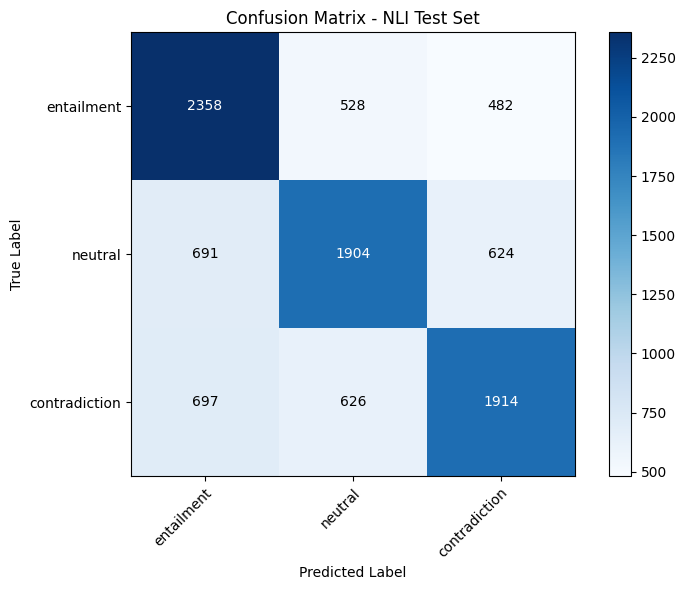


Overall Test Accuracy: 62.87%


In [42]:
# ==================== Confusion Matrix Visualization ====================
# I reuse the filtered labels/predictions (excluding invalid -1 labels) from above
cm = confusion_matrix(filtered_labels, filtered_preds, labels=[0, 1, 2])

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Set labels
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=target_names,
       yticklabels=target_names,
       title='Confusion Matrix - NLI Test Set',
       ylabel='True Label',
       xlabel='Predicted Label')

# Rotate tick labels for readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Annotate cells with counts
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()

# Print overall accuracy
accuracy = np.sum(np.array(filtered_preds) == np.array(filtered_labels)) / len(filtered_labels)
print(f"\nOverall Test Accuracy: {accuracy * 100:.2f}%")

### Discussion: Limitations, Challenges, and Potential Improvements

#### Limitations and Challenges

1. **Custom Vocabulary vs. Subword Tokenization:** I built a word-level vocabulary from the WikiText dataset, which means out-of-vocabulary (OOV) words in the NLI dataset are mapped to the `[MASK]` token. This is a significant limitation compared to BERT's original WordPiece tokenizer, which handles rare words through subword decomposition. Many words in the SNLI premises and hypotheses may not appear in the WikiText vocabulary, leading to information loss.

2. **Limited Pre-training Data and Epochs:** Due to computational constraints, I pre-trained BERT on a subset of WikiText-103 (~100K samples) for only 100 epochs with a small batch size of 6. The original BERT was pre-trained on the entire BookCorpus (800M words) and English Wikipedia (2,500M words) for much longer. This limited pre-training means the model has not learned sufficiently rich contextual representations.

3. **Simplified Architecture:** While I follow the original BERT architecture, I use 6 layers and 8 heads (similar to BERT-base uses 12 layers and 12 heads). This reduced capacity limits the model's ability to capture complex linguistic patterns.

4. **Training Data Subset:** I used only 50K SNLI training samples instead of the full ~550K dataset to keep training time reasonable. More training data would improve generalization.

#### Potential Improvements

1. **Use a pre-trained tokenizer** (e.g., BertTokenizer from Hugging Face) or train a BPE/WordPiece tokenizer on the dataset to handle OOV words properly.

2. **Increase pre-training duration and data:** Train on the full WikiText-103 or BookCorpus dataset for more epochs to learn better language representations before fine-tuning.

3. **Use the full SNLI dataset** for S-BERT fine-tuning (all ~550K training samples) to improve downstream performance.

4. **Combine SNLI with MNLI** as done in the original S-BERT paper to increase training data diversity across genres.

5. **Apply data augmentation** techniques like back-translation or synonym replacement to increase training data diversity.

6. **Experiment with different pooling strategies:** The S-BERT paper found that mean pooling works best, but CLS token pooling or max pooling could also be explored.

7. **Hyperparameter tuning:** Experiment with different learning rates, batch sizes, and warmup ratios for better convergence.

## Task 4. Text similarity - Web Application Development
**Develop a simple web application that demonstrates the capabilities of your text-embedding model. (1 points)**

1) Develop a simple website with two input boxes for search queries.
2) Utilize a custom-trained sentence transformer model to predict Natural Language Inference (NLI) Task (entailment, neutral and contradiction).

For example:
* **Premise:** A man is playing a guitar on stage.
* **Hypothesis:** The man is performing music.
* **Label:** Entailment

Good luck :-)

### Web Application Implementation

I developed a Flask web application that demonstrates the NLI capabilities of the trained Sentence-BERT model. The app follows a clean **MVC-style separation** with dedicated files for routing, utilities, templates, and static assets.

---

#### Project Structure

```
app/
├── app.py                  # Flask application (routes & entry point)
├── utils.py                # Model definitions, tokenization, prediction logic
├── templates/
│   └── index.html          # Jinja2 HTML template
└── static/
    ├── css/
    │   └── style.css       # Stylesheet (loft / minimal aesthetic)
    └── js/
        └── main.js         # Client-side form handling & result display
```

---

#### File Descriptions

| File | Role | Key Contents |
|---|---|---|
| `app.py` | **Flask Server** | Initializes Flask app, loads model at startup via `load_model()`, defines two routes: `GET /` (serve page) and `POST /predict` (run inference) |
| `utils.py` | **Utilities** | Contains all model class definitions (`Embedding`, `BERT`, etc.), `tokenize_sentence()`, `mean_pool()`, `predict_nli()`, and `load_model()` |
| `index.html` | **Template** | Jinja2 template with two `<textarea>` inputs (Premise & Hypothesis), a Predict button, and a result card showing label, confidence, and cosine similarity |
| `style.css` | **Styling** | Loft / minimal design: warm beige background (`#f5f0eb`), white card surface, Inter font, subtle shadows, CSS custom properties for theming |
| `main.js` | **Client Logic** | Handles form submission via `fetch('/predict')`, manages loading spinner, and dynamically updates the result UI with the JSON response |

#### How the Web Application Works

The application follows a **client-server architecture** where the Flask backend handles model inference and the frontend provides an interactive user interface.

---

##### 1. Server Startup (`app.py`)

When the server starts, it performs a **one-time model loading** step:

```python
bert_model, classifier_head, word2id, device = load_model(model_dir='../model')
```

The `load_model()` function in `utils.py`:
1. Loads the custom vocabulary (`vocab.pkl`) containing the `word2id` dictionary built from WikiText-103
2. Loads the saved checkpoint (`sbert_nli.pth`) which stores both the BERT backbone weights and classifier head weights
3. Reconstructs the `BERT` model and `classifier_head` (Linear layer) using the saved hyperparameters
4. Sets both models to evaluation mode (`.eval()`) to disable dropout

---

##### 2. Prediction Pipeline (`POST /predict`)

When a user submits a premise-hypothesis pair, the following pipeline executes:

![Pipeline](assets/pipeline.png)

---

##### 3. Frontend Interaction (`main.js`)

The client-side JavaScript handles the user experience:

1. **Form Submission** — Intercepts the form `submit` event, prevents page reload
2. **Async Fetch** — Sends a `POST` request to `/predict` with JSON body `{ premise, hypothesis }`
3. **Loading State** — Shows a spinner and disables the button during inference
4. **Result Display** — Parses the JSON response and updates:
   - The prediction label badge (color-coded: green = entailment, amber = neutral, red = contradiction)
   - Confidence percentage (softmax probability of predicted class)
   - Cosine similarity score (semantic relatedness between sentence embeddings)
5. **Error Handling** — Catches network/server errors and displays an alert

---

##### 4. Design Philosophy

The UI follows a **loft / minimal aesthetic**:
- **Warm beige background** (`#f5f0eb`) for a calm, paper-like feel
- **White card surface** with subtle `box-shadow` for depth
- **Inter font family** for clean, modern typography
- **CSS custom properties** (`:root` variables) for consistent theming
- **Responsive layout** — single-column card, max-width 640px, scales on mobile
- **Color-coded labels** — semantic colors for each NLI class (green/amber/red)

---

##### How to Run

```bash
# 1. Ensure model files exist
#    model/sbert_nli.pth   (trained S-BERT checkpoint)
#    model/vocab.pkl        (word2id vocabulary)

# 2. Navigate to app directory
cd app

# 3. Install dependencies (if needed)
pip install flask torch scikit-learn

# 4. Start the server
python app.py

# 5. Open browser at http://localhost:5000
```

#### Key Source Code

Below are the core components of the web application for reference.

---

##### `app.py` — Flask Server (Routes Only)

```python
from flask import Flask, render_template, request, jsonify
from utils import load_model, predict_nli

app = Flask(__name__)
bert_model, classifier_head, word2id, device = load_model(model_dir='../model')

@app.route("/")
def index():
    return render_template("index.html")

@app.route("/predict", methods=["POST"])
def predict():
    data = request.get_json()
    premise = data.get("premise", "").strip()
    hypothesis = data.get("hypothesis", "").strip()
    if not premise or not hypothesis:
        return jsonify({"error": "Both premise and hypothesis are required"}), 400
    result = predict_nli(premise, hypothesis, bert_model, classifier_head, word2id, device)
    return jsonify(result)

if __name__ == "__main__":
    app.run(debug=False, host="0.0.0.0", port=5000)
```

---

##### `utils.py` — Prediction Function (Core Logic)

```python
def predict_nli(premise, hypothesis, bert_model, classifier_head, word2id, device):
    with torch.no_grad():
        # Tokenize both sentences
        p_ids, p_mask, p_seg = tokenize_sentence(premise, word2id)
        h_ids, h_mask, h_seg = tokenize_sentence(hypothesis, word2id)

        # Convert to tensors and move to device
        p_ids_t = torch.LongTensor([p_ids]).to(device)
        h_ids_t = torch.LongTensor([h_ids]).to(device)
        # ... (attention masks and segment ids similarly)

        # Get BERT hidden states
        u_hidden = bert_model.get_last_hidden_state(p_ids_t, p_seg_t)
        v_hidden = bert_model.get_last_hidden_state(h_ids_t, h_seg_t)

        # Mean pooling → sentence embeddings
        u = mean_pool(u_hidden, p_mask_t)  # (1, 768)
        v = mean_pool(v_hidden, h_mask_t)  # (1, 768)

        # Cosine similarity
        sim = cosine_similarity(u.cpu().numpy(), v.cpu().numpy())[0, 0]

        # Classification: [u; v; |u-v|] → Linear → Softmax
        x = torch.cat([u, v, torch.abs(u - v)], dim=-1)  # (1, 2304)
        logits = classifier_head(x)
        probs = F.softmax(logits, dim=-1)
        pred_class = torch.argmax(probs, dim=-1).item()

    return {"label": LABEL_MAP[pred_class], "confidence": probs[0, pred_class].item(),
            "similarity": float(sim), "color": LABEL_COLORS[pred_class]}
```

---

##### `main.js` — Client-Side Fetch Logic

```javascript
form.addEventListener('submit', async (e) => {
    e.preventDefault();
    const premise = document.getElementById('premise').value.trim();
    const hypothesis = document.getElementById('hypothesis').value.trim();
    // Show loading spinner
    const response = await fetch('/predict', {
        method: 'POST',
        headers: { 'Content-Type': 'application/json' },
        body: JSON.stringify({ premise, hypothesis }),
    });
    const data = await response.json();
    // Update UI: label badge, confidence %, cosine similarity
    resultTag.textContent = data.label;
    resultTag.style.backgroundColor = data.color;
    confidence.textContent = (data.confidence * 100).toFixed(1) + '%';
    similarity.textContent = data.similarity.toFixed(4);
});
```

### References
* Devlin, J., et al. (2019). "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding." https://aclanthology.org/N19-1423.pdf
* Reimers, N. & Gurevych, I. (2019). "Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks." https://aclanthology.org/D19-1410/
* WikiText-103 Dataset: https://huggingface.co/datasets/Salesforce/wikitext
* SNLI Dataset: https://huggingface.co/datasets/stanfordnlp/snli
* Bowman, S. R., et al. (2015). "A large annotated corpus for learning natural language inference." https://aclanthology.org/D15-1075/